#  Preprocessing Utilities

## Installations & Imports

### Installations

In [1]:
import sys
!{sys.executable} -m pip install --quiet scikit-image

^C
ERROR: Operation cancelled by user


In [2]:
!{sys.executable} -m pip install --quiet imantics

### Imports

In [1]:
from PIL import Image
from pathlib import Path as Data_Path
from os import listdir
from os.path import isfile, join
from tqdm.notebook import tqdm
from IPython.display import Image as NB_Image
from skimage.transform import resize
from skimage.io import imsave, imread
from skimage.util import img_as_ubyte
from shapely import wkt
from shapely.geometry import mapping, Polygon

import numpy as np
import multiprocessing as mp
import json
import matplotlib.pyplot as plt
from matplotlib.path import Path

### Initialization

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
# This removes the massive amount of scikit warnings of "low contrast images"
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
%matplotlib inline

## Image Visualizations

In [6]:
DATA_PATH = Data_Path("/Volumes/LaCie/Building_Damage_Assessment")

In [7]:
TRAIN_IMAGE_PATH = join(DATA_PATH, 'train', 'images')
TRAIN_LABEL_PATH = join(DATA_PATH, 'train', 'labels')

In [8]:
def get_label_path(image_name):
    label = image_name.split('.')[0] + '.json'
    return join(TRAIN_LABEL_PATH, label)

In [9]:
if not DATA_PATH.exists():
    print("Oops, file doesn't exist!")
else:
    print("Yay, the file exists!")

Yay, the file exists!


In [10]:
train_image_names = [f for f in listdir(TRAIN_IMAGE_PATH) if isfile(join(TRAIN_IMAGE_PATH, f))]
train_image_names

['guatemala-volcano_00000000_post_disaster.png',
 'guatemala-volcano_00000000_pre_disaster.png',
 'guatemala-volcano_00000001_post_disaster.png',
 'guatemala-volcano_00000001_pre_disaster.png',
 'guatemala-volcano_00000002_post_disaster.png',
 'guatemala-volcano_00000002_pre_disaster.png',
 'guatemala-volcano_00000006_post_disaster.png',
 'guatemala-volcano_00000006_pre_disaster.png',
 'guatemala-volcano_00000007_post_disaster.png',
 'guatemala-volcano_00000007_pre_disaster.png',
 'guatemala-volcano_00000008_post_disaster.png',
 'guatemala-volcano_00000008_pre_disaster.png',
 'guatemala-volcano_00000010_post_disaster.png',
 'guatemala-volcano_00000010_pre_disaster.png',
 'guatemala-volcano_00000013_post_disaster.png',
 'guatemala-volcano_00000013_pre_disaster.png',
 'guatemala-volcano_00000015_post_disaster.png',
 'guatemala-volcano_00000015_pre_disaster.png',
 'guatemala-volcano_00000016_post_disaster.png',
 'guatemala-volcano_00000016_pre_disaster.png',
 'guatemala-volcano_00000017_p

In [10]:
test_image = train_image_names[5304]
test_image

'socal-fire_00001176_post_disaster.png'

In [13]:
test_image = 'hurricane-michael_00000196_post_disaster.png'

In [14]:
im = Image.open(join(TRAIN_IMAGE_PATH, test_image))
im.show()

In [12]:
test_image_array = get_image(join(TRAIN_IMAGE_PATH, test_image))

In [10]:
def get_image(fname):    
    """
    :param fname: a filepath to the image
    :returns: the image in ndarray format
    """
    return np.array(Image.open(fname))

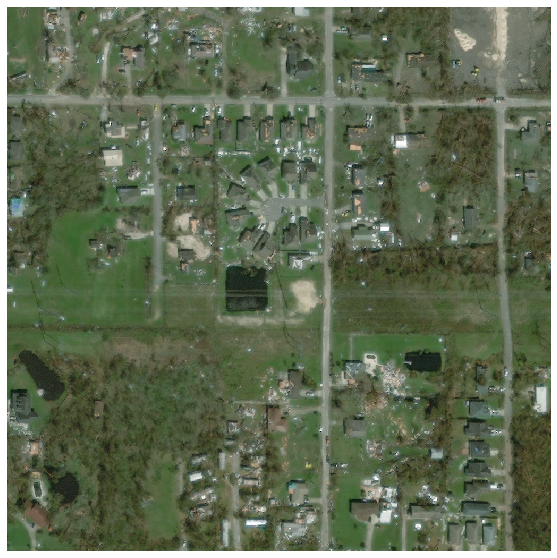

In [18]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(get_image(join(TRAIN_IMAGE_PATH, test_image)))

In [14]:
get_label_path(test_image)

'/Volumes/LaCie/Building_Damage_Assessment/train/labels/socal-fire_00001176_post_disaster.json'

In [15]:
get_labels(get_label_path(test_image))

  0%|          | 0/41 [00:00<?, ?it/s]


KeyError: 'bounds_imcoords'

### Overlays

In [11]:
#import json 
from PIL import Image, ImageDraw
from IPython.display import display
from shapely import wkt

In [20]:
# Opening and loading polygons from label json 
path_to_image_value = join(TRAIN_IMAGE_PATH, test_image)
path_to_label_value = get_label_path(test_image)

with open(path_to_label_value, 'rb') as image_json_file:
    image_json = json.load(image_json_file)

In [21]:
coords = image_json['features']['xy']
wkt_polygons = []

for coord in coords:
    if 'subtype' in coord['properties']:
        damage = coord['properties']['subtype']
    else:
        damage = 'no-damage'
    wkt_polygons.append((damage, coord['wkt']))
    
polygons = []

for damage, swkt in wkt_polygons:
    polygons.append((damage, wkt.loads(swkt)))

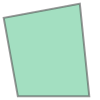

In [22]:
polygons[0][1]

In [23]:
# Loading image
img = Image.open(path_to_image_value)

In [38]:
def visualize_damage_overlays(label_path, image_path, image_name):
    """
    :param label_path: path to the labels in json format
    :param image_path: path to the image in png format
    :param image_name: file name of the image to visualize
    """
    
    # Opening and loading polygons from label json 
    path_to_image_value = join(image_path, image_name)
    path_to_label_value = label_path

    with open(path_to_label_value, 'rb') as image_json_file:
        image_json = json.load(image_json_file)

    coords = image_json['features']['xy']
    wkt_polygons = []

    for coord in coords:
        if 'subtype' in coord['properties']:
            damage = coord['properties']['subtype']
        else:
            damage = 'no-damage'
        wkt_polygons.append((damage, coord['wkt']))

    polygons = []

    for damage, swkt in wkt_polygons:
        polygons.append((damage, wkt.loads(swkt)))

    img = Image.open(path_to_image_value)
    draw = ImageDraw.Draw(img, 'RGBA')

    damage_dict = {
        "no-damage": (0, 255, 0, 100),
        "minor-damage": (255, 255, 0, 100),
        "major-damage": (255, 69, 0, 100),
        "destroyed": (255, 0, 0, 100),
        "un-classified": (255, 255, 255, 100)
    }

    for damage, polygon in polygons:
        x,y = polygon.exterior.coords.xy
        coords = list(zip(x,y))
        draw.polygon(coords, damage_dict[damage])

    del draw

    display(img)

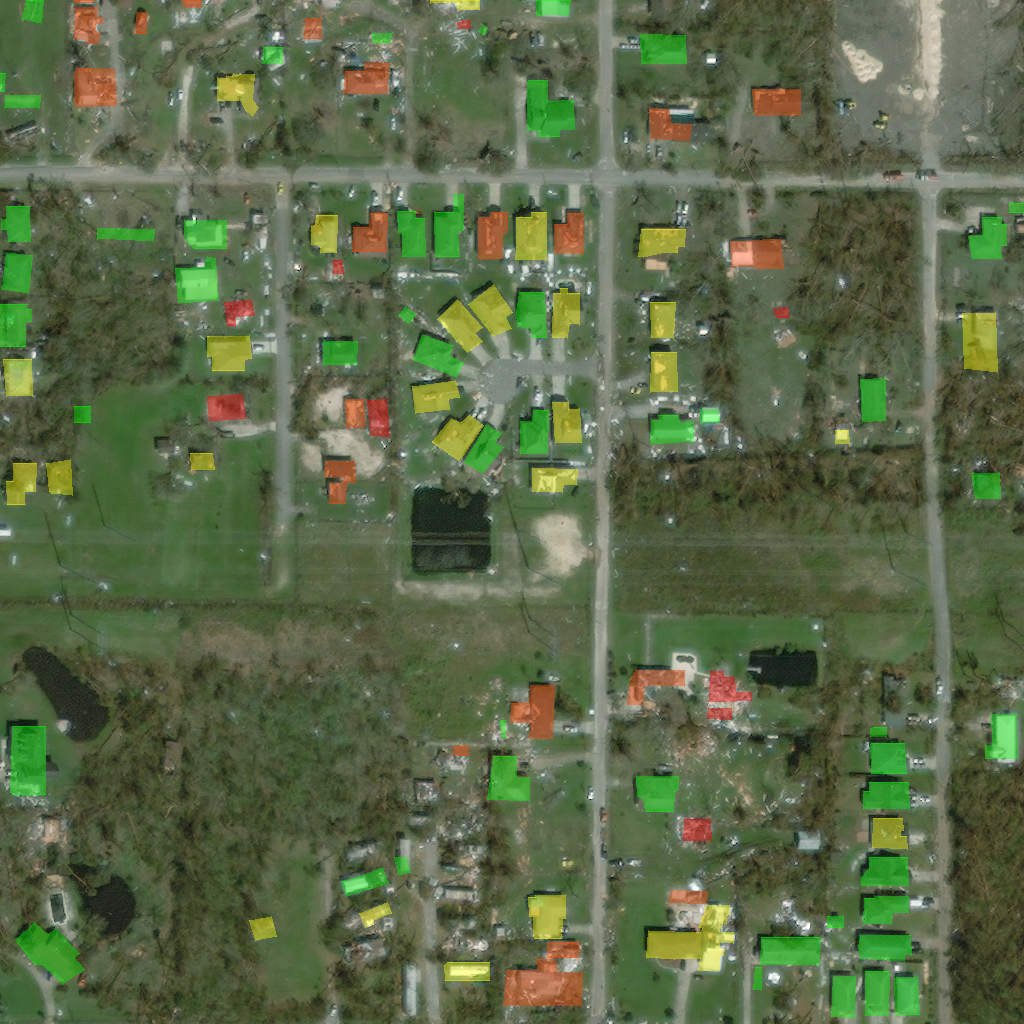

In [39]:
visualize_damage_overlays(get_label_path(test_image), TRAIN_IMAGE_PATH, test_image)

## Preprocessing Pipeline

In [6]:
IMG_SHAPE = (1024, 1024)
TARGET_SHAPE = (200, 200)

def read_json(json_path):
    """
    :param json_path: path to load json from
    :returns: a python dictionary of json features
    """
    with open(json_path, 'rb') as image_json_file:
        image_json = json.load(image_json_file)
    return image_json


def get_image(fname):    
    """
    :param fname: a filepath to the image
    :returns: the image in ndarray format
    """
    return np.array(Image.open(fname))


def get_feature_info(feature):
    """
    :param feature: a python dictionary of json labels
    :returns: a list mapping of polygons contained in the image 
    """
    # Getting each polygon points from the json file and adding it to a dictionary of uid:polygons
    props = {}

    for feat in feature['features']['xy']:
        feat_shape = wkt.loads(feat['wkt'])
        coords = list(mapping(feat_shape)['coordinates'][0])
        
        if 'subtype' in feat['properties']:
            damage = feat['properties']['subtype']
        else:
            damage = 'no-damage'
        
        bounding_box = box_from_coords(np.array(coords, np.int32))
        props[feat['properties']['uid'] + '_' + damage] = [feat_shape, bounding_box]

    return props


def box_from_coords(coords):
    """
    :param coords: an array of bounding box coordinates
    :returns: an array of shape (4,) with the bounding box coordinates of coords in proper format
    """
    x1,x2 = coords[:,0].min(),coords[:,0].max()
    y1,y2 = coords[:,1].min(),coords[:,1].max()
    box = [x1,y1,x2,y2]
    return np.array(box, np.int32)


def get_square_bounding(masked_img, bounding_box):
    """
    :param masked_img: the masked image in ndarray format
    :param bounding_box: the rectangular bounding box of the building
    :returns: the minimum square bounding box coordinates
    """
    x_length = bounding_box[2] - bounding_box[0]
    y_length = bounding_box[3] - bounding_box[1]
    
    if x_length >= y_length:
        even_square_length = x_length if x_length % 2 == 0 else x_length + 1
        even_y_length = y_length if y_length % 2 == 0 else y_length + 1
        padding = (even_square_length - even_y_length) / 2
        return np.array([bounding_box[0], bounding_box[1] - padding, bounding_box[0] + even_square_length, \
                         bounding_box[1] - padding + even_square_length]).astype(np.int32)
        
    else:
        even_square_length = y_length if y_length % 2 == 0 else y_length + 1
        even_x_length = x_length if x_length % 2 == 0 else x_length + 1
        padding = (even_square_length - even_x_length) / 2
        return np.array([bounding_box[0] - padding, bounding_box[1], bounding_box[0] - padding + even_square_length, \
                         bounding_box[1] + even_square_length]).astype(np.int32)

    
def resize_img(masked_img, bounding_box):
    """
    :param masked_img: the masked image in ndarray format
    :param bounding_box: the rectangular bounding box of the building
    :returns: a masked image in ndarray of just the building in TARGET_SHAPE shape
    """
    try:
        square_coords = get_square_bounding(masked_img, bounding_box) + 500
        padded_img = np.pad(masked_img, ((500, 500), (500, 500), (0, 0)))
        cut_img = padded_img[square_coords[1]:square_coords[3], square_coords[0]:square_coords[2], :]
        r_img = resize(cut_img, TARGET_SHAPE)
        
    except:
        print(square_coords)
        plt.figure(figsize=(10,10))
        plt.imshow(padded_img)
        
    return r_img
    

def masked_building_image(img, polygon, coors):
    """
    :param img: the image to be masked
    :param polygon: the shapely polygon of a building
    :param coors: the bounding box coordinates of the building
    :returns: the masked image only showing the building
    """
    
    polygon_pts = np.array(list(polygon.exterior.coords))
    poly_path = Path(polygon_pts)
    
    width, height = IMG_SHAPE
    x, y = np.mgrid[:height, :width]
    coors = np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    mask = poly_path.contains_points(coors).reshape(height, width).T
    
    img_masked = np.zeros(img.shape, dtype=img.dtype)
    img_masked[mask] = img[mask]
    return img_masked


def save_image(img, output_path, label_name, building_id):
    """
    :param img: the resized, masked image building
    :param output_path: the desired output path
    :param label_name: the filename of the label json
    :param building_id: the generated building id
    """
    filename = label_name.split('.')[0] + '_' + building_id + '.png'
    imsave(join(output_path, filename), img_as_ubyte(img))


def process_image(input_data):
    """
    :param input_data: tuple containing all input data for parallel processing
    """
    
    (img_name, label_names, image_path, label_path, output_path, black_mask) = input_data
        
    label_name = img_name.split('.')[0] + '.json'
    assert label_name in label_names, 'No label exists for image: {}'.format(img_name)

    label_json = read_json(join(label_path, label_name))
    building_info = get_feature_info(label_json)

    img = get_image(join(image_path, img_name))

    for building_id, (polygon, box_coors) in building_info.items():
        m_image = img
        if black_mask:
            m_image = masked_building_image(img, polygon, box_coors)
        r_image = resize_img(m_image, box_coors)
        save_image(r_image, output_path, label_name, building_id)
    
    
def pool_resize_image(input_data):
    """
    :param input_data: tuple containing all input data for parallel processing
    """
    
    (img_name, image_path, output_path, target_shape) = input_data
    img = get_image(join(image_path, img_name))
    r_image = resize(img, target_shape)
    imsave(join(output_path, img_name), img_as_ubyte(r_image))
        
        
def generate_resized_images(image_path, output_path, target_shape):
    """
    :param image_path: the path name to all images
    :param output_path: the path name to where the processed images should be saved
    :param target_shape: the target shape
    """
    
    # Get filenames of all images and labels
    img_names = [f for f in listdir(image_path) if isfile(join(image_path, f)) and '.png' in f]
    
    pool_input = [(name, image_path, output_path, target_shape) for name in img_names]
    with mp.Pool(mp.cpu_count()) as p:
        _ = list(tqdm(p.imap(pool_resize_image, pool_input), desc='Images Processed: ', unit='images', total=len(img_names)))
    

def generate_building_images(image_path, label_path, output_path, black_mask=False, must_contain=None, multi_processing=False):
    """
    :param image_path: the path name to all images
    :param label_path: the path name to all labels
    :param output_path: the path name to where the processed images should be saved
    :param black_mask: boolean whether the image outside the building bounds should be blacked out
    :param must_contain: array of strings the images filenames must contain in order to be processed
    """
    
    # Get filenames of all images and labels
    img_names = [f for f in listdir(image_path) if isfile(join(image_path, f)) and '.png' in f]
    label_names = [f for f in listdir(label_path) if isfile(join(label_path, f)) and '.json' in f]
    
    if must_contain:
        for s in must_contain:
            img_names = [i for i in img_names if s in i]
            label_names = [l for l in label_names if s in l]
            
    if multi_processing:
        pool_input = [(name, label_names, image_path, label_path, output_path, black_mask) for name in img_names]
        with mp.Pool(mp.cpu_count()) as p:
            _ = list(tqdm(p.imap(process_image, pool_input), desc='Images Processed: ', unit='images', total=len(img_names)))
            
    else:
        for img_name in tqdm(img_names, desc='Images Processed: ', unit='images', leave=True):

            label_name = img_name.split('.')[0] + '.json'
            assert label_name in label_names, 'No label exists for image: {}'.format(img_name)

            label_json = read_json(join(label_path, label_name))
            building_info = get_feature_info(label_json)

            img = get_image(join(image_path, img_name))

            for building_id, (polygon, box_coors) in tqdm(building_info.items(), desc='Buildings Processed: ', unit='buildings', leave=False):
                m_image = img
                if black_mask:
                    m_image = masked_building_image(img, polygon, box_coors)
                r_image = resize_img(m_image, box_coors)
                save_image(r_image, output_path, label_name, building_id)

In [7]:
DATA_PATH = Data_Path("/Volumes/LaCie/Building_Damage_Assessment")

In [8]:
TEST_PATH = Data_Path('/Users/lukashaas/Stanford/3 Junior/1 Fall/CS 229/Project/Code')

In [9]:
disasters = ['socal-fire', 'santa-rosa-wildfire', 'palu-tsunami', 'guatemala-volcano', 'midwest-flooding', 
             'hurricane-florence', 'hurricane-harvey', 'hurricane-matthew', 'hurricane-michael', 'mexico-earthquake']

In [10]:
hurricanes = [x for x in disasters if 'hurricane' in x]
hurricanes

['hurricane-florence',
 'hurricane-harvey',
 'hurricane-matthew',
 'hurricane-michael']

In [11]:
pathname = join(DATA_PATH, 'test', 'resized_images_224')

In [12]:
# Create directories
for disaster in hurricanes:
    full_path = pathname + '/{}-post'.format(disaster)
    path = Data_Path(full_path)
    path.mkdir()

In [13]:
# Resize Images
target_size = 224
for disaster in tqdm(hurricanes, desc='Disasters Processed: ', unit='hurricanes', total=len(hurricanes)):
    print('Hurricane:', disaster)
    INPUT_PATH = join(DATA_PATH, 'test', 'resized_images', '{}-post'.format(disaster))
    OUTPUT_PATH = join(DATA_PATH, 'test', 'resized_images_{}'.format(target_size), '{}-post'.format(disaster))
    generate_resized_images(INPUT_PATH, OUTPUT_PATH, (target_size, target_size))

Hurricane: hurricane-florence



Hurricane: hurricane-harvey



Hurricane: hurricane-matthew



Hurricane: hurricane-michael


In [101]:
TRAIN_IMAGE_PATH = join(DATA_PATH, 'test', 'images')
TRAIN_LABEL_PATH = join(DATA_PATH, 'test', 'labels')
TRAIN_OUTPUT_PATH = join(DATA_PATH, 'test', 'resized_images', '{}-post'.format(disasters[9]))
TRAIN_OUTPUT_PATH

'/Volumes/LaCie/Building_Damage_Assessment/test/resized_images/mexico-earthquake-post'

In [102]:
for disaster in tqdm(disasters, desc='Disasters Processed: ', unit='disasters', total=len(disasters)):
    print('Disaster: ' + disaster)
    TRAIN_OUTPUT_PATH = join(DATA_PATH, 'test', 'resized_images', '{}-post'.format(disaster))
    generate_building_images(TRAIN_IMAGE_PATH, TRAIN_LABEL_PATH, TRAIN_OUTPUT_PATH, multi_processing=True, black_mask=False, must_contain=[disaster, 'post_'])

Disaster: socal-fire



Disaster: santa-rosa-wildfire



Disaster: palu-tsunami



Disaster: guatemala-volcano



Disaster: midwest-flooding



Disaster: hurricane-florence



Disaster: hurricane-harvey



Disaster: hurricane-matthew



Disaster: hurricane-michael



Disaster: mexico-earthquake


In [47]:
TEST_IMAGE_PATH = join(TEST_PATH, 'test_images')
TEST_LABEL_PATH = join(TEST_PATH, 'test_labels')
TEST_OUTPUT_PATH = join(TEST_PATH, 'test_masks')

## Experimentation

In [31]:
test_image = get_image(join(TEST_IMAGE_PATH, [f for f in listdir(TEST_IMAGE_PATH) if isfile(join(TEST_IMAGE_PATH, f)) and '.png' in f][0]))

In [38]:
test_image_pad = np.pad(test_image, ((100, 100), (100, 100), (0, 0)))

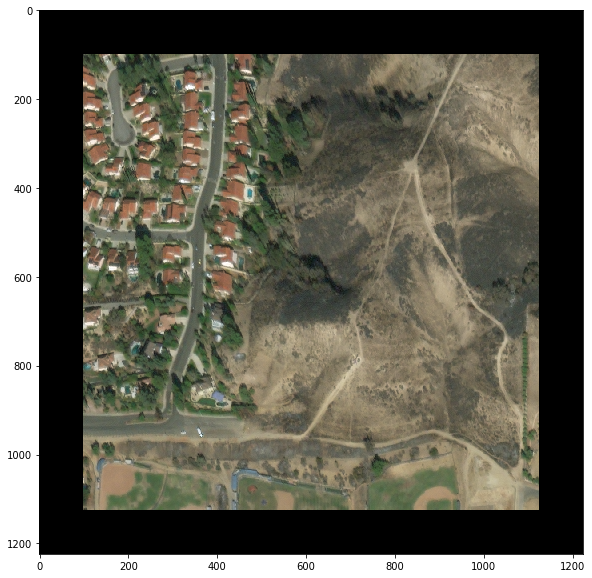

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(test_image_pad)

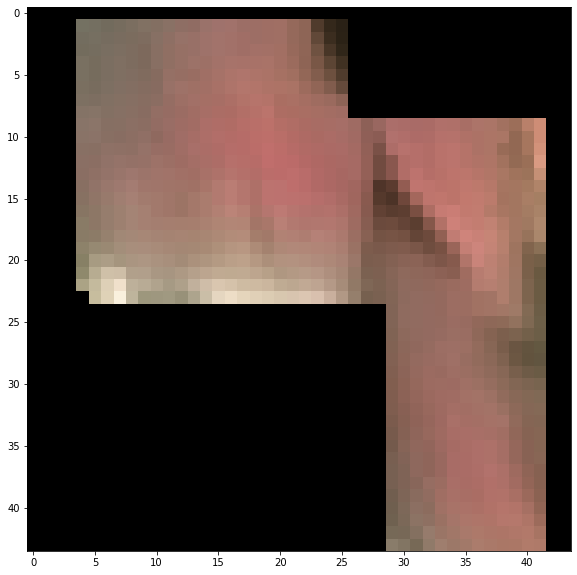

In [346]:
plt.figure(figsize=(10,10))
plt.imshow(masked_img)

In [186]:
polygons[0:3]

[('no-damage', <shapely.geometry.polygon.Polygon at 0x62f30f160>),
 ('no-damage', <shapely.geometry.polygon.Polygon at 0x62f32a6a0>),
 ('no-damage', <shapely.geometry.polygon.Polygon at 0x62f32ab00>)]

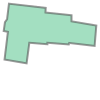

In [192]:
test_shape = polygons[-4][1]
test_shape

In [195]:
polygon_pts = np.array(list(test_shape.exterior.coords))

In [212]:
polygon_bounding_box = np.array(list(test_shape.bounds)).astype(np.int32)

In [213]:
polygon_bounding_box

array([375, 661, 434, 699], dtype=int32)

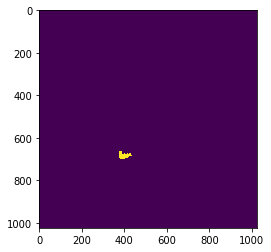

In [197]:
width, height = 1024, 1024
poly_path = Path(polygon_pts)
x, y = np.mgrid[:height, :width]
coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
mask = poly_path.contains_points(coors).reshape(height, width).T
plt.imshow(mask);

In [ ]:
width, height = 1024, 1024
poly_path = Path(polygon_pts)
x, y = np.mgrid[:height, :width]
coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
mask = poly_path.contains_points(coors).reshape(height, width).T
plt.imshow(mask);

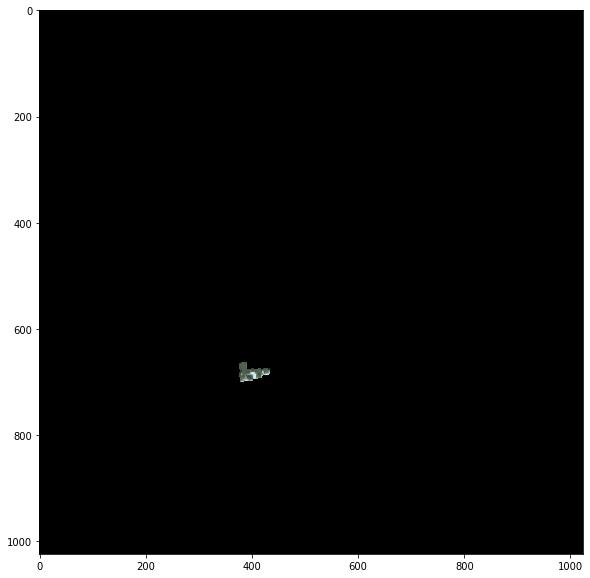

In [215]:
img_masked = np.zeros(test_img.shape,dtype=test_img.dtype)
img_masked[mask] = test_img[mask]
plt.figure(figsize=(10,10))
plt.imshow(img_masked)

In [219]:
img_masked.shape

(1024, 1024, 3)

In [232]:
def get_bounding_square(masked_img, bounding_box):
    x_length = bounding_box[2] - bounding_box[0]
    y_length = bounding_box[3] - bounding_box[1]
    
    if x_length >= y_length:
        even_square_length = x_length if x_length % 2 == 0 else x_length + 1
        even_y_length = y_length if y_length % 2 == 0 else y_length + 1
        padding = (even_square_length - even_y_length) / 2
        return np.array([bounding_box[0], bounding_box[1] - padding, bounding_box[0] + even_square_length, bounding_box[1] - padding + even_square_length]).astype(np.int32)
        
    else:
        even_square_length = y_length if y_length % 2 == 0 else y_length + 1
        even_x_length = x_length if x_length % 2 == 0 else x_length + 1
        padding = (even_square_length - even_x_length) / 2
        return np.array([bounding_box[0] - padding, bounding_box[1], bounding_box[0] - padding + even_square_length, bounding_box[1] + even_square_length]).astype(np.int32)

In [234]:
square_mask = get_bounding_square(img_masked, polygon_bounding_box)
square_mask

array([375, 650, 435, 710], dtype=int32)

In [276]:
sized_img_masked = img_masked[square_mask[1]:square_mask[3], square_mask[0]:square_mask[2], :]

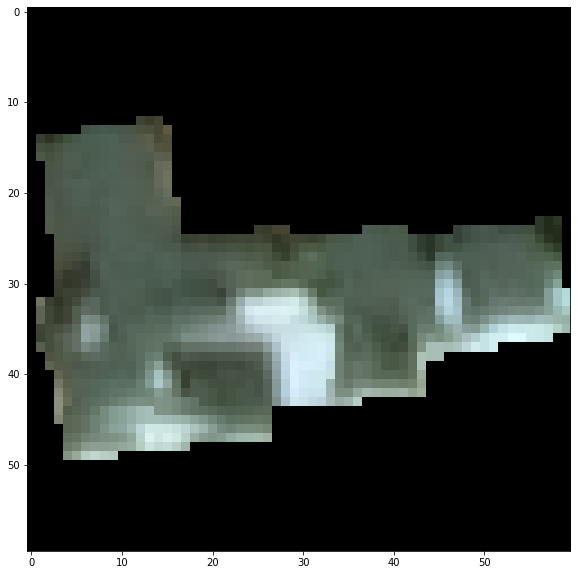

In [277]:
plt.figure(figsize=(10,10))
plt.imshow(sized_img_masked)

In [278]:
resized_img_masked = resize(sized_img_masked, (200, 200))

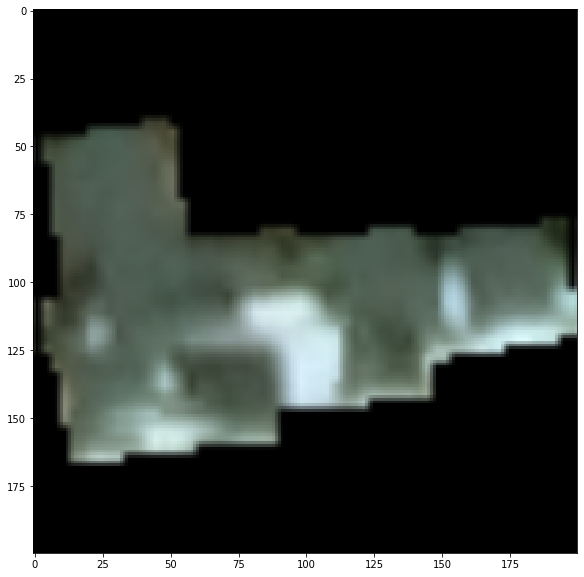

In [279]:
plt.figure(figsize=(10,10))
plt.imshow(resized_img_masked)

In [292]:
output_name = test_img_name.split('.')[0] + '_ID' + '.png'
output_name

'socal-fire_00001176_post_disaster_ID.png'

In [294]:
imsave(join(test_output_dir, output_name), img_as_ubyte(resized_img_masked))

In [70]:
img = get_image(join(test_image_dir, test_image))

In [151]:
test_classes = np.ones((len(building_coords), 1))

In [152]:
c_img, c_box, c_cls = chip_image(img=img, coords=np.array(building_coords), classes=test_classes, shape=(200,200))

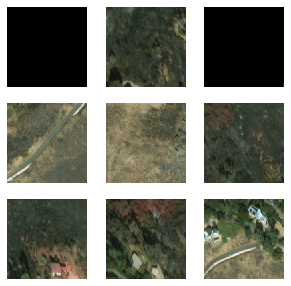

In [155]:
fig,ax = plt.subplots(3)
fig.set_figheight(5)
fig.set_figwidth(5)

for k in range(9):
    plt.subplot(3,3,k+1)
    plt.axis('off')
    plt.imshow(c_img[np.random.choice(range(c_img.shape[0]))])

plt.show()

In [ ]:
draw = ImageDraw.Draw(img, 'RGBA')

damage_dict = {
    "no-damage": (0, 255, 0, 100),
    "minor-damage": (0, 0, 255, 125),
    "major-damage": (255, 69, 0, 125),
    "destroyed": (255, 0, 0, 125),
    "un-classified": (255, 255, 255, 125)
}

for damage, polygon in polygons:
    x,y = polygon.exterior.coords.xy
    coords = list(zip(x,y))
    draw.polygon(coords, damage_dict[damage])

del draw

display(img)